In [2]:
# All the imports we need
import numpy as np
import gtsam
from gtsam.utils.plot import plot_pose3
from matplotlib import pyplot as plt
from gtsam.symbol_shorthand import B, V, X
from gtbook.display import show
from mpl_toolkits.mplot3d import Axes3D

try:
  # For Google Colab
  from google.colab import output
  output.enable_custom_widget_manager()
  print(" -- Custom widgets enabled")
except:
  pass

# For interactive plots
%matplotlib widget

def vector3(x, y, z):
    """Create 3d double numpy array."""
    return np.array([x, y, z], dtype=float)

In [3]:
T = 24  # The timespan of our trajectory.
dt = 1e-2  # 100 Hz frequency
velocity = np.array([2, 0, 0])  # The velocity we wish to move at.


scenarios = {
    "zero_twist": (np.zeros(3), np.zeros(3)),  # Zero motion, stationary trajectory.
    "forward_motion": (np.zeros(3), velocity),  # Move forward in the x axis at 2 m/s.
    "loop": (np.array([0, -np.radians(30), 0]), velocity),  # A loop-de-loop trajectory.
    "sick": (np.array([np.radians(30), -np.radians(30), 0]), velocity)  # A spiral trajectory, "sick" in surfer slang.
}


def plot_scenario(scenario,
                  T,
                  dt,
                  title="IMU trajectory scenario",
                  fignum=0,
                  maxDim=5):
    for t in np.arange(0, T, dt):
        actualPose = scenario.pose(t)
        plot_pose3(fignum, actualPose, axis_length=0.3)

        translation = actualPose.translation()
        maxDim = max([max(np.abs(translation)), maxDim])
        ax = plt.gca()
        ax.set_xlim3d(-maxDim, maxDim)
        ax.set_ylim3d(-maxDim, maxDim)
        ax.set_zlim3d(-maxDim, maxDim)
        ax.set_title(title)
    

    plt.show()

In [4]:
scenario = gtsam.ConstantTwistScenario(*scenarios["forward_motion"])

In [5]:
accBias = np.array([-0.3, 0.1, 0.2])
gyroBias = np.array([0.1, 0.3, -0.1])
# accBias = np.array([-0.0, 0.0, 0.0])
# gyroBias = np.array([0.0, 0.0, -0.0])
actualBias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

pim_params = gtsam.PreintegrationParams.MakeSharedU(9.81)

# Some arbitrary noise sigmas
gyro_sigma = 1e-3
accel_sigma = 1e-3
I_3x3 = np.eye(3)
pim_params.setGyroscopeCovariance(gyro_sigma**2 * I_3x3)
pim_params.setAccelerometerCovariance(accel_sigma**2 * I_3x3)
pim_params.setIntegrationCovariance(1e-7**2 * I_3x3)
g = 9.81
n_gravity = vector3(0, 0, -g)

BIAS_COVARIANCE = gtsam.noiseModel.Isotropic.Variance(6, 0.1)

# Define the PreintegratedImuMeasurements object here.
pim = gtsam.PreintegratedImuMeasurements(pim_params, actualBias)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)
# plot_scenario(scenario, T, dt, fignum=6)

In [6]:
isam = gtsam.ISAM2()
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

In [7]:
def add_priors(scenario, graph, initial, isam):
    # Noise models for
    priorNoise = gtsam.noiseModel.Isotropic.Sigma(6, 0.1)
    velNoise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

    initial_state = scenario.navState(0)
    graph.push_back(
        gtsam.PriorFactorPose3(X(0), initial_state.pose(), priorNoise))
    graph.push_back(
        gtsam.PriorFactorVector(V(0), initial_state.velocity(), velNoise))
    
    graph.push_back(gtsam.PriorFactorConstantBias(B(0), actualBias, gtsam.noiseModel.Isotropic.Sigma(6, 0.1)))

    initial.insert(B(0), actualBias)
    initial.insert(X(0), initial_state.pose())
    initial.insert(V(0), initial_state.velocity())

    isam.update(graph, initial)
    result = isam.calculateEstimate()
    graph = gtsam.NonlinearFactorGraph()
    initial.clear()

    
    return graph, initial, isam, result


graph, initial, isam, result = add_priors(scenario, graph, initial, isam)


In [8]:
def main_loop(runner, scenario, graph, initial, isam, T, result):
    # The factor index for the estimation rate
    i = 0
    bias_key = B(0)
    PERIOD = 1 # in seconds


    for k, t in enumerate(np.arange(0, T, dt)):
        # get measurements and add them to PIM

        measuredOmega = runner.measuredAngularVelocity(t)
        measuredAcc = runner.measuredSpecificForce(t)

        ### This is where all the magic happens!
        pim.integrateMeasurement(measuredAcc, measuredOmega, dt)

       
        if (k + 1) % int((1 / dt) * PERIOD) == 0:

             # These are additive noise terms (for simulation purposes)
            rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.10)
            translationNoise = gtsam.Point3(*np.random.randn(3) * 1)
            poseNoise = gtsam.Pose3(rotationNoise, translationNoise)


            # noisy_state_i = pim.predict(scenario.navState,actualBias)


            if i == 0:
                actual_state_i = scenario.navState(t)
                noisy_state_i = gtsam.NavState(
                actual_state_i.pose().compose(poseNoise),
                actual_state_i.velocity() + np.random.randn(3) * 0.1)

                initial.insert(X(1), noisy_state_i.pose())
                initial.insert(V(1), noisy_state_i.velocity())
            elif i >=2:
                actual_state_i = scenario.navState(t + dt)
                noisy_state_i = gtsam.NavState(
                actual_state_i.pose().compose(poseNoise),
                actual_state_i.velocity() + np.random.randn(3) * 0.1)

                initial.insert(X(i), noisy_state_i.pose())
                initial.insert(V(i), noisy_state_i.velocity())

            if i > 0:

                # Create IMU factor every second.

                # add Bias between factor

                if i % 5 == 0:
                    bias_key += 1
                    initial.insert(bias_key, actualBias)
                    # note that gtsam.imuBias.ConstantBias() defaults to zeroes
                    bias_between_factor = gtsam.BetweenFactorConstantBias(bias_key - 1, bias_key, gtsam.imuBias.ConstantBias(), BIAS_COVARIANCE)
                    graph.add(bias_between_factor)

                    
                # print("bias key: ", bias_key)
                
                factor = gtsam.ImuFactor(X(i - 1), V(i - 1), X(i), V(i), bias_key, pim)
                graph.push_back(factor)

                # We have created the binary constraint, so we clear out the preintegration values.
                pim.resetIntegration()

         
            i += 1


            # print('About to update')

            isam.update(graph, initial)
            result = isam.calculateEstimate()
            graph = gtsam.NonlinearFactorGraph()
            initial.clear()
            

    return graph, result

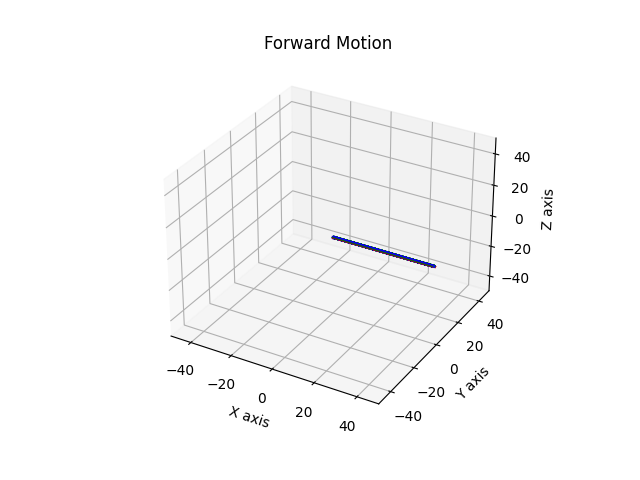

Result:  Values with 53 values:
Value b0: (gtsam::imuBias::ConstantBias)
acc = -0.3  0.1  0.2 gyro =      0.1 0.299999     -0.1

Value b1: (gtsam::imuBias::ConstantBias)
acc = -0.300001       0.1       0.2 gyro = 0.0999882   0.29997      -0.1

Value b2: (gtsam::imuBias::ConstantBias)
acc = -0.300001       0.1       0.2 gyro = 0.0999849  0.299963 -0.100001

Value b3: (gtsam::imuBias::ConstantBias)
acc = -0.300001       0.1       0.2 gyro = 0.0999843  0.299963 -0.100001

Value b4: (gtsam::imuBias::ConstantBias)
acc = -0.300001       0.1       0.2 gyro = 0.0999843  0.299963 -0.100001

Value v0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2;
	4.10053e-10;
	1.19814e-09
]

Value v1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2.01216;
	0.0264163;
	-0.000560575
]

Value v2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2.03316;
	0.0459456;
	-0.00130966
]

Value v3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2.06591;
	0.0651801;
	0.000265187
]

Value v4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)

In [9]:
plot_scenario(scenario, T, dt, title="Forward Motion", fignum=1)

graph, result = main_loop(runner, scenario, graph, initial, isam, T, result)

print('Result: ', result)

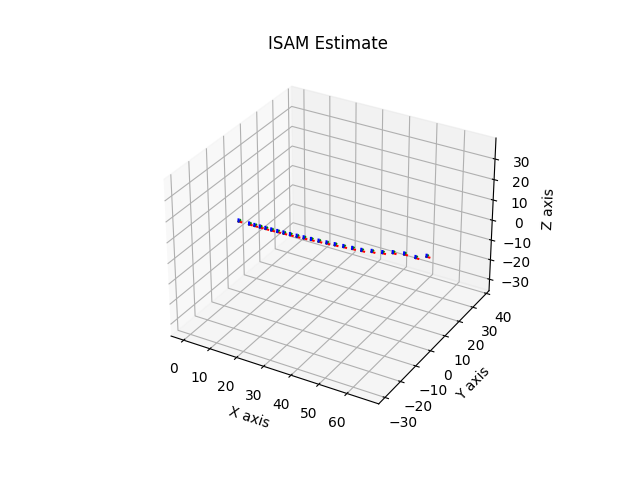

In [10]:
def plot_trajectory(values: gtsam.Values,
                    title: str = "Estimated Trajectory",
                    fignum: int = 1,
                    show: bool = False):
    i = 0
    while values.exists(X(i)):
        pose_i = values.atPose3(X(i))
        plot_pose3(fignum, pose_i, 1)
        i += 1
    plt.title(title)

    gtsam.utils.plot.set_axes_equal(fignum)

    plt.ioff()

    if show:
        plt.show()


plot_trajectory(result, title="ISAM Estimate", fignum=2, show=True)

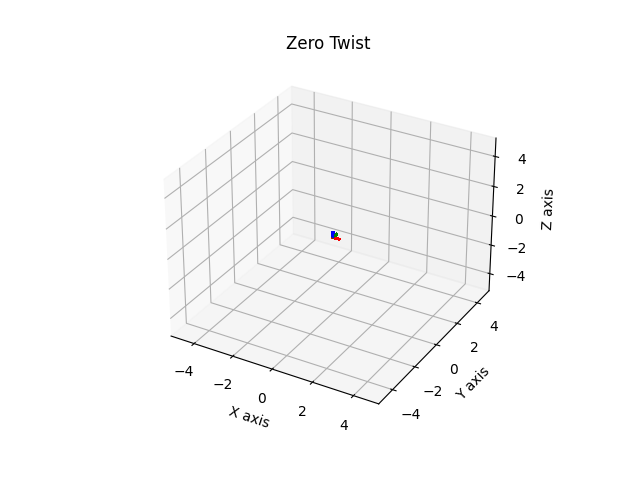

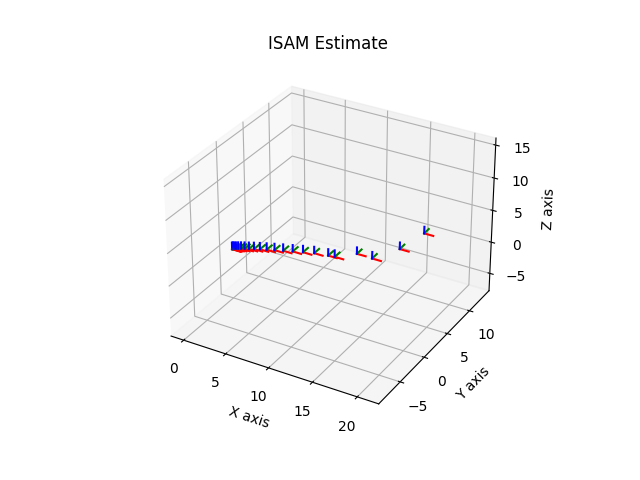

In [11]:
scenario = gtsam.ConstantTwistScenario(*scenarios["zero_twist"])
plot_scenario(scenario, T, dt, title="Zero Twist", fignum=3)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
isam = gtsam.ISAM2()

graph, initial, isam, result = add_priors(scenario, graph, initial, isam)
graph, result = main_loop(runner, scenario, graph, initial, isam, T, result)
plot_trajectory(result, title="ISAM Estimate", fignum=4, show=True)



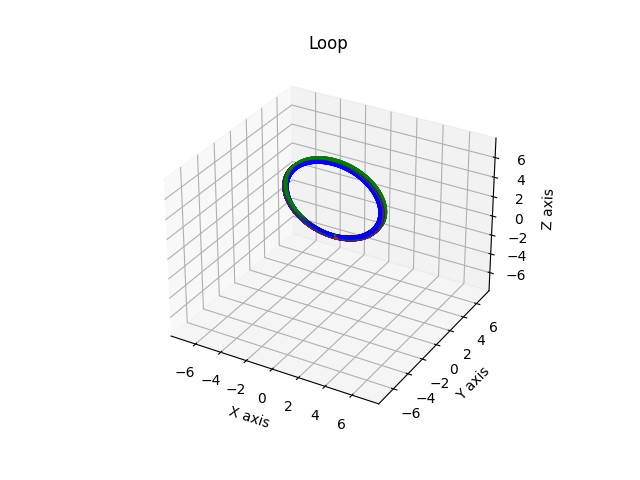

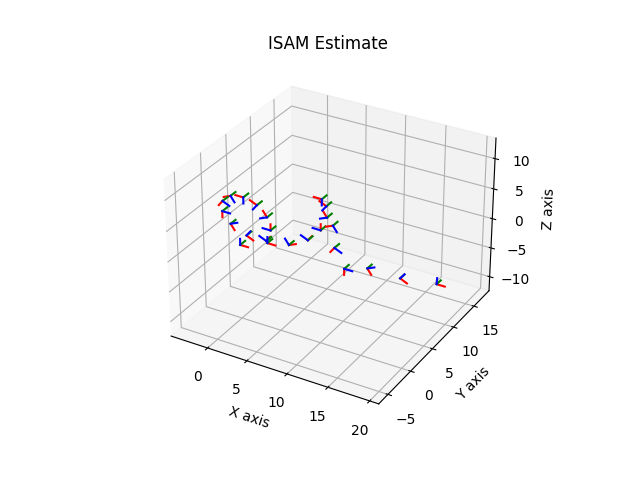

In [12]:
scenario = gtsam.ConstantTwistScenario(*scenarios["loop"])
plot_scenario(scenario, T, dt, title="Loop", fignum=5)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
isam = gtsam.ISAM2()

graph, initial, isam, result = add_priors(scenario, graph, initial, isam)
graph, result = main_loop(runner, scenario, graph, initial, isam, T, result)
plot_trajectory(result, title="ISAM Estimate", fignum=6, show=True)

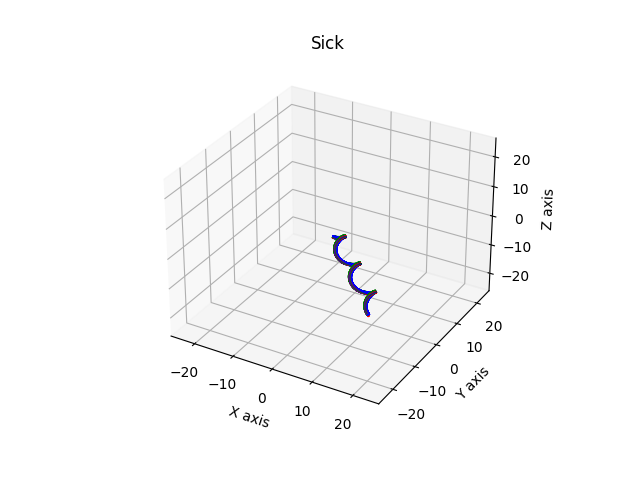

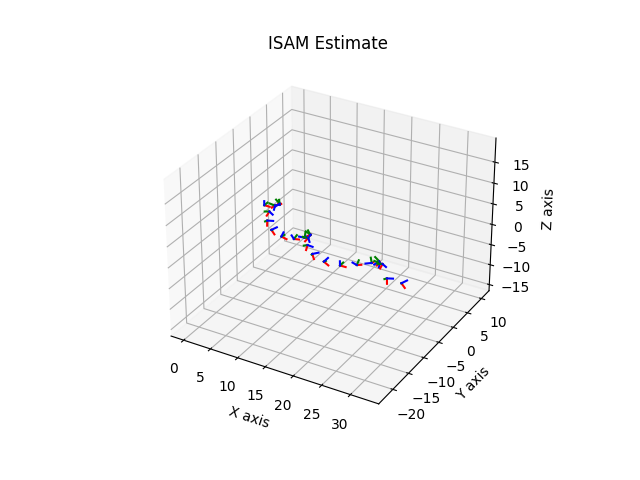

In [13]:
scenario = gtsam.ConstantTwistScenario(*scenarios["sick"])
plot_scenario(scenario, T, dt, title="Sick", fignum=7)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
isam = gtsam.ISAM2()

graph, initial, isam, result = add_priors(scenario, graph, initial, isam)
graph, result = main_loop(runner, scenario, graph, initial, isam, T, result)
plot_trajectory(result, title="ISAM Estimate", fignum=8, show=True)